<!-- # Copyright (c) 2025 takotime808 -->

# Constrained LHS ##

Constrain an LHS based on a user defined constraining function that references 
variables by column name from user input csv file.


Bad key text.markup in file /Users/tako/.matplotlib/matplotlibrc, line 165 ("text.markup         : 'plain'  # Affects how text, such as titles and labels, are")
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.6.3/matplotlibrc.template
or from the matplotlib source distribution


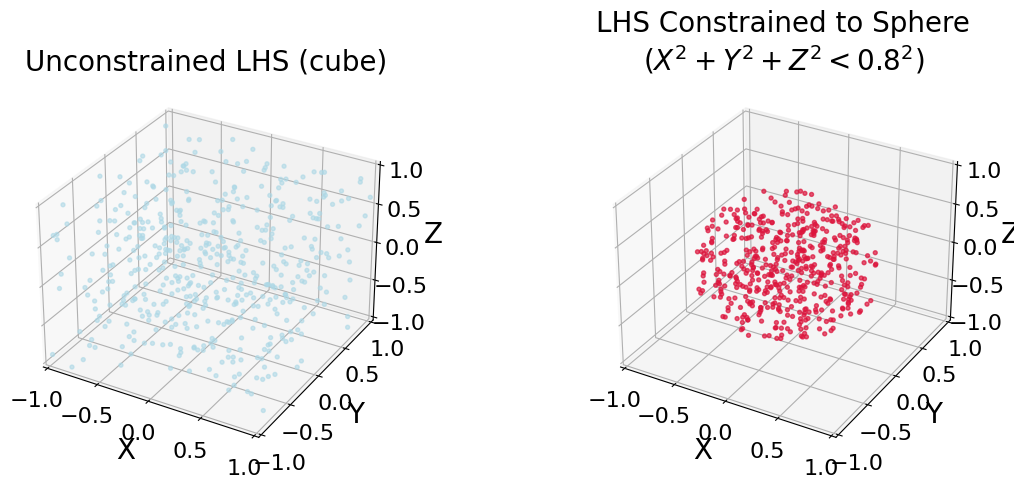

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    from pyDOE3 import lhs
except ImportError:
    def lhs(
        n: int,
        samples: int = None,
        random_state: np.random.RandomState = None,
        **kwargs
    ) -> np.ndarray:
        if random_state is None:
            random_state = np.random.RandomState()
        if samples is None:
            samples = n
        cut = np.linspace(0, 1, samples + 1)
        u = random_state.rand(samples, n)
        a = cut[:samples]
        b = cut[1 : samples + 1]
        rdpoints = np.zeros_like(u)
        for j in range(n):
            rdpoints[:, j] = u[:, j] * (b - a) + a
        H = np.zeros_like(rdpoints)
        for j in range(n):
            order = random_state.permutation(range(samples))
            H[:, j] = rdpoints[order, j]
        return H

def constrained_lhs_from_df(
    n_samples: int,
    df: pd.DataFrame,
    constraint_str: str,
    max_iter: int = 10000,
    plot: bool = False
) -> pd.DataFrame:
    columns = df.columns.tolist()
    n_features = len(columns)
    bounds = [(df[c].min(), df[c].max()) for c in columns]
    valid_samples = []
    iter_count = 0
    batch_size = max(100, n_samples*2)
    while len(valid_samples) < n_samples and iter_count < max_iter:
        samples = lhs(n_features, samples=batch_size)
        for i, (low, high) in enumerate(bounds):
            samples[:, i] = low + (high - low) * samples[:, i]
        samples_df = pd.DataFrame(samples, columns=columns)
        for idx, row in samples_df.iterrows():
            try:
                if eval(constraint_str, {}, row.to_dict()):
                    valid_samples.append(row.values)
            except Exception:
                continue
        iter_count += batch_size
    if len(valid_samples) < n_samples:
        raise ValueError(f"Could only find {len(valid_samples)} samples within {max_iter} iterations!")
    valid_samples_df = pd.DataFrame(valid_samples[:n_samples], columns=columns)
    return valid_samples_df

def make_3d_plot_of_constrained_lhs(
        df_uncon: pd.DataFrame,
        df_con: pd.DataFrame,
        x_name: str = 'X',
        y_name: str = 'Y',
        z_name: str = 'Z',
        r: float = 0.6,
        savefig: str = False,
):
    """
    Visualize 3D Latin Hypercube samples before and after applying a spherical constraint.

    Parameters
    ----------
    df_uncon : pd.DataFrame
        DataFrame of unconstrained LHS samples.
    df_con : pd.DataFrame
        DataFrame of constrained LHS samples.
    x_name, y_name, z_name : str
        Axis column names.
    r : float
        Used for title only.
    savefig : str or bool
        Save path or show interactively.
    """
    fig = plt.figure(figsize=(12, 5))

    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(df_uncon[x_name], df_uncon[y_name], df_uncon[z_name], color='lightblue', s=8, alpha=0.6)
    ax1.set_title('Unconstrained LHS (cube)')
    ax1.set_xlabel(x_name)
    ax1.set_ylabel(y_name)
    ax1.set_zlabel(z_name)
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([-1, 1])
    ax1.set_zlim([-1, 1])

    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(df_con[x_name], df_con[y_name], df_con[z_name], color='crimson', s=8, alpha=0.7)
    ax2.set_title(f'LHS Constrained to Sphere\n(${x_name}^2 + {y_name}^2 + {z_name}^2 < {r}^2$)')
    ax2.set_xlabel(x_name)
    ax2.set_ylabel(y_name)
    ax2.set_zlabel(z_name)
    ax2.set_xlim([-1, 1])
    ax2.set_ylim([-1, 1])
    ax2.set_zlim([-1, 1])

    plt.tight_layout()
    if savefig:
        plt.savefig(savefig)
        plt.close()
    else:
        plt.show()

# --- Example usage ---
n_samples = 500
r_value = 0.8  # can be different for each sample if you wish

# DataFrame bounds for X, Y, Z between -1 and 1, r as a constant column
df = pd.DataFrame({
    'X': [-1, 1],
    'Y': [-1, 1],
    'Z': [-1, 1],
    'r': [r_value, r_value]  # same r for all, but now available as a variable!
})

# Unconstrained LHS
unconstrained = lhs(4, samples=n_samples)  # note: now 4 columns
unconstrained = pd.DataFrame(unconstrained, columns=['X', 'Y', 'Z', 'r'])
unconstrained['X'] = -1 + 2 * unconstrained['X']
unconstrained['Y'] = -1 + 2 * unconstrained['Y']
unconstrained['Z'] = -1 + 2 * unconstrained['Z']
unconstrained['r'] = r_value  # could set a vector of r values here!

# Constraint uses 'r' column for each sample:
sphere_constraint = "X**2 + Y**2 + Z**2 < r**2"

df_con = constrained_lhs_from_df(
    n_samples=n_samples,
    df=df,
    constraint_str=sphere_constraint,
    plot=False
)

make_3d_plot_of_constrained_lhs(
    df_uncon=unconstrained,
    df_con=df_con,
    x_name='X',
    y_name='Y',
    z_name='Z',
    r=r_value,
)


<!-- # Copyright (c) 2025 takotime808 -->

### Vary the Radius `r`

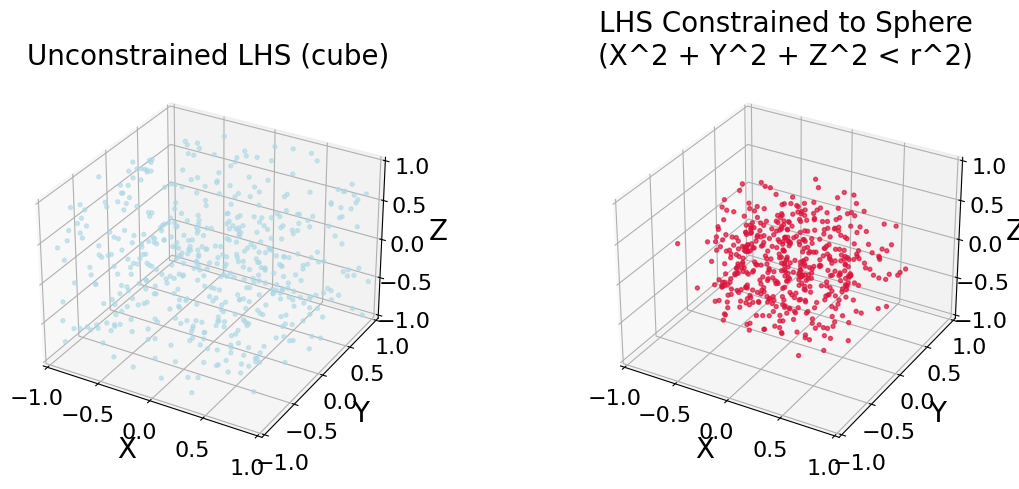

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Minimal LHS fallback if pyDOE3 is not installed
def lhs(n, samples=None, random_state=None):
    if random_state is None:
        random_state = np.random.RandomState()
    if samples is None:
        samples = n
    cut = np.linspace(0, 1, samples + 1)
    u = random_state.rand(samples, n)
    a = cut[:samples]
    b = cut[1 : samples + 1]
    rdpoints = np.zeros_like(u)
    for j in range(n):
        rdpoints[:, j] = u[:, j] * (b - a) + a
    H = np.zeros_like(rdpoints)
    for j in range(n):
        order = random_state.permutation(range(samples))
        H[:, j] = rdpoints[order, j]
    return H

def constrained_lhs_from_df(
    n_samples: int,
    df: pd.DataFrame,
    constraint_str: str,
    max_iter: int = 10000,
    plot: bool = False
) -> pd.DataFrame:
    columns = df.columns.tolist()
    n_features = len(columns)
    bounds = [(df[c].min(), df[c].max()) for c in columns]
    valid_samples = []
    iter_count = 0
    batch_size = max(100, n_samples*2)
    while len(valid_samples) < n_samples and iter_count < max_iter:
        samples = lhs(n_features, samples=batch_size)
        for i, (low, high) in enumerate(bounds):
            samples[:, i] = low + (high - low) * samples[:, i]
        samples_df = pd.DataFrame(samples, columns=columns)
        for idx, row in samples_df.iterrows():
            try:
                if eval(constraint_str, {}, row.to_dict()):
                    valid_samples.append(row.values)
            except Exception:
                continue
        iter_count += batch_size
    if len(valid_samples) < n_samples:
        raise ValueError(f"Could only find {len(valid_samples)} samples within {max_iter} iterations!")
    valid_samples_df = pd.DataFrame(valid_samples[:n_samples], columns=columns)
    return valid_samples_df

def make_3d_plot_of_constrained_lhs(
        df_uncon: pd.DataFrame,
        df_con: pd.DataFrame,
        x_name: str = 'X',
        y_name: str = 'Y',
        z_name: str = 'Z',
        r: float = 0.6,
        savefig: str = False,
):
    fig = plt.figure(figsize=(12, 5))
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(df_uncon[x_name], df_uncon[y_name], df_uncon[z_name], color='lightblue', s=8, alpha=0.6)
    ax1.set_title('Unconstrained LHS (cube)')
    ax1.set_xlabel(x_name)
    ax1.set_ylabel(y_name)
    ax1.set_zlabel(z_name)
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([-1, 1])
    ax1.set_zlim([-1, 1])
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(df_con[x_name], df_con[y_name], df_con[z_name], color='crimson', s=8, alpha=0.7)
    ax2.set_title(f'LHS Constrained to Sphere\n({x_name}^2 + {y_name}^2 + {z_name}^2 < r^2)')
    ax2.set_xlabel(x_name)
    ax2.set_ylabel(y_name)
    ax2.set_zlabel(z_name)
    ax2.set_xlim([-1, 1])
    ax2.set_ylim([-1, 1])
    ax2.set_zlim([-1, 1])
    plt.tight_layout()
    if savefig:
        plt.savefig(savefig)
        plt.close()
    else:
        plt.show()

# --- Example usage ---
n_samples = 500

# Define r range for random radii per sample
r_min, r_max = 0.2, 1.0

# DataFrame bounds for X, Y, Z between -1 and 1, r between r_min and r_max
df = pd.DataFrame({
    'X': [-1, 1],
    'Y': [-1, 1],
    'Z': [-1, 1],
    'r': [r_min, r_max]
})

# Unconstrained LHS
unconstrained = lhs(4, samples=n_samples)
df_uncon = pd.DataFrame(unconstrained, columns=['X', 'Y', 'Z', 'r'])
df_uncon['X'] = -1 + 2 * df_uncon['X']
df_uncon['Y'] = -1 + 2 * df_uncon['Y']
df_uncon['Z'] = -1 + 2 * df_uncon['Z']
df_uncon['r'] = r_min + (r_max - r_min) * df_uncon['r']

# Constraint uses per-sample r value
sphere_constraint = "X**2 + Y**2 + Z**2 < r**2"

df_con = constrained_lhs_from_df(
    n_samples=n_samples,
    df=df,
    constraint_str=sphere_constraint,
    plot=False
)

make_3d_plot_of_constrained_lhs(
    df_uncon=df_uncon,
    df_con=df_con,
    x_name='X',
    y_name='Y',
    z_name='Z',
    r=None,
)


<!-- # Copyright (c) 2025 takotime808 -->

### Add Plot of Data Removed by Constraint

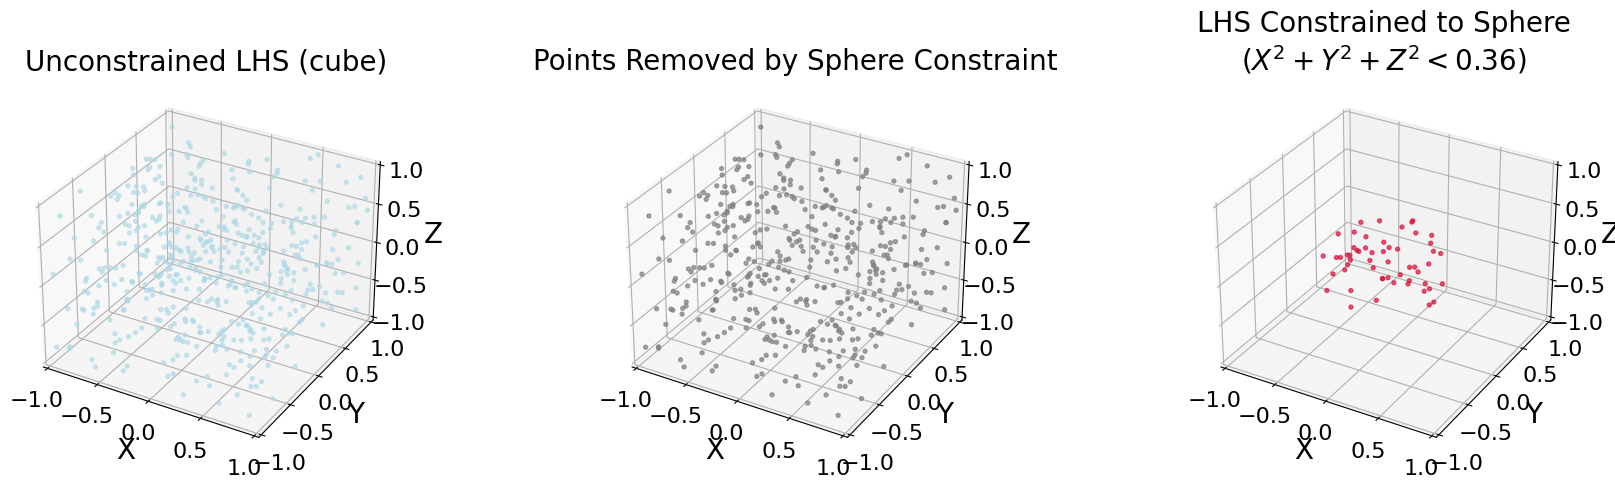

In [3]:
# Parameters
n_samples = 500
r = 0.6

# Unconstrained LHS in cube [-1, 1]^3
cube_samples = lhs(3, samples=n_samples)
cube_samples = -1 + 2*cube_samples
df_cube = pd.DataFrame(cube_samples, columns=['X', 'Y', 'Z'])

# Calculate inside/outside the sphere mask
radius_sq = r**2
dist_sq = df_cube['X']**2 + df_cube['Y']**2 + df_cube['Z']**2
inside_mask = dist_sq < radius_sq

# Points inside sphere
df_inside = df_cube[inside_mask]
# Points outside sphere (removed)
df_outside = df_cube[~inside_mask]

# Plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(18, 5))

# 1. Unconstrained LHS
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(df_cube['X'], df_cube['Y'], df_cube['Z'], color='lightblue', s=8, alpha=0.6)
ax1.set_title('Unconstrained LHS (cube)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_xlim([-1, 1])
ax1.set_ylim([-1, 1])
ax1.set_zlim([-1, 1])

# 2. Points removed by constraint
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(df_outside['X'], df_outside['Y'], df_outside['Z'], color='gray', s=8, alpha=0.7)
ax2.set_title('Points Removed by Sphere Constraint')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_xlim([-1, 1])
ax2.set_ylim([-1, 1])
ax2.set_zlim([-1, 1])

# 3. Points inside sphere (constrained)
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(df_inside['X'], df_inside['Y'], df_inside['Z'], color='crimson', s=8, alpha=0.7)
ax3.set_title(f'LHS Constrained to Sphere\n($X^2 + Y^2 + Z^2 < {r**2}$)')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')
ax3.set_xlim([-1, 1])
ax3.set_ylim([-1, 1])
ax3.set_zlim([-1, 1])

plt.tight_layout()
plt.show()


<!-- # Copyright (c) 2025 takotime808 -->

### Change How `r` is Used in Constraining Function, `sphere_constraint`

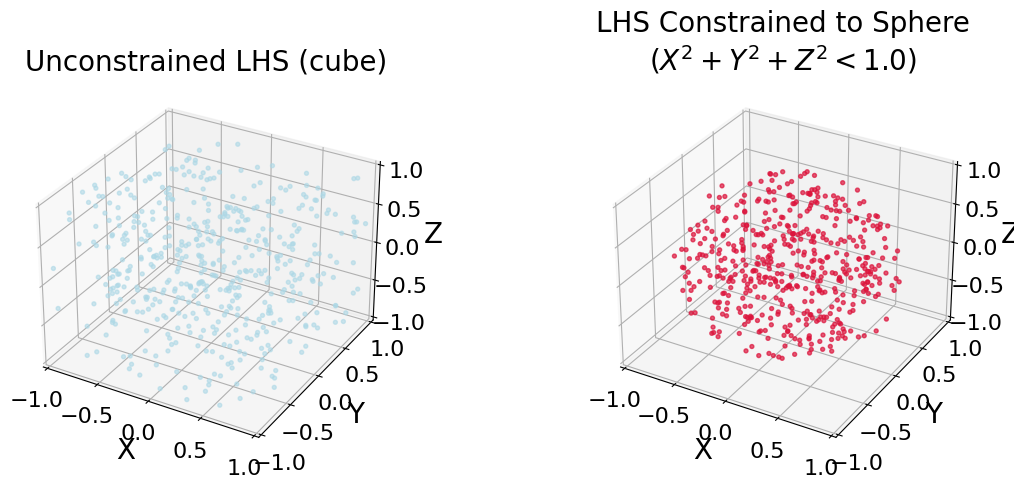

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
try:
    from pyDOE3 import lhs
except ImportError:
    def lhs(
        n: int,
        samples: Optional[int] = None,
        criterion: Optional[str] = None,
        iterations: Optional[int] = None,
        random_state: Optional[np.random.RandomState] = None,
        correlation_matrix: Optional[np.ndarray] = None
    ) -> np.ndarray:
        """
        Basic Latin Hypercube Sampling (LHS) implementation.

        Parameters
        ----------
        n : int
            Number of features (dimensions).
        samples : int, optional
            Number of samples to generate.
        criterion : str, optional
            Not used here; placeholder for compatibility.
        iterations : int, optional
            Not used here; placeholder for compatibility.
        random_state : np.random.RandomState, optional
            Random state for reproducibility.
        correlation_matrix : np.ndarray, optional
            Not used here; placeholder for compatibility.

        Returns
        -------
        np.ndarray
            LHS sample of shape (samples, n).
        """
        # ... [Use your function above: omitted here for brevity, copy from earlier cell] ...
        # -- paste the full lhs implementation from before here! --
        # [for this environment, using a basic LHS]
        if random_state is None:
            random_state = np.random.RandomState()
        if samples is None:
            samples = n
        cut = np.linspace(0, 1, samples + 1)
        u = random_state.rand(samples, n)
        a = cut[:samples]
        b = cut[1 : samples + 1]
        rdpoints = np.zeros_like(u)
        for j in range(n):
            rdpoints[:, j] = u[:, j] * (b - a) + a
        H = np.zeros_like(rdpoints)
        for j in range(n):
            order = random_state.permutation(range(samples))
            H[:, j] = rdpoints[order, j]
        return H

def constrained_lhs_from_df(
    n_samples: int,
    df: pd.DataFrame,
    constraint_str: str,
    max_iter: int = 10000,
    plot: bool = False
) -> pd.DataFrame:
    """
    Generate a Latin Hypercube Sample within bounds defined by a DataFrame,
    subject to an arbitrary constraint.

    Parameters
    ----------
    n_samples : int
        Number of samples to return.
    df : pd.DataFrame
        DataFrame with columns as variables and min/max as two rows for each.
    constraint_str : str
        A string evaluated for each sample (e.g., "X**2 + Y**2 + Z**2 < 0.5").
    max_iter : int, optional
        Maximum LHS draws to attempt before raising an error.
    plot : bool, optional
        If True, plot samples (not used in current code).

    Returns
    -------
    pd.DataFrame
        DataFrame of shape (n_samples, n_features) containing valid samples.
    """
    columns = df.columns.tolist()
    n_features = len(columns)
    bounds = [(df[c].min(), df[c].max()) for c in columns]
    valid_samples = []
    iter_count = 0
    batch_size = max(100, n_samples*2)
    while len(valid_samples) < n_samples and iter_count < max_iter:
        samples = lhs(n_features, samples=batch_size)
        for i, (low, high) in enumerate(bounds):
            samples[:, i] = low + (high - low) * samples[:, i]
        samples_df = pd.DataFrame(samples, columns=columns)
        for idx, row in samples_df.iterrows():
            try:
                if eval(constraint_str, {}, row.to_dict()):
                    valid_samples.append(row.values)
            except Exception:
                continue
        iter_count += batch_size
    if len(valid_samples) < n_samples:
        raise ValueError(f"Could only find {len(valid_samples)} samples within {max_iter} iterations!")
    valid_samples_df = pd.DataFrame(valid_samples[:n_samples], columns=columns)
    return valid_samples_df

def make_3d_plot_of_constrained_lhs(
        df_uncon: pd.DataFrame,
        df_con: pd.DataFrame,
        x_name: str = 'X',
        y_name: str = 'Y',
        z_name: str = 'Z',
        r: float = 0.6,
        savefig: str = False,
):
    """
    Visualize 3D Latin Hypercube samples before and after applying a spherical constraint.

    This function creates a side-by-side 3D scatter plot comparing:
      1. Unconstrained LHS samples (typically filling a cube)
      2. Samples that satisfy a sphere constraint, e.g. (x^2 + y^2 + z^2 < r^2)

    Parameters
    ----------
    df_uncon : pd.DataFrame
        DataFrame of unconstrained LHS samples. Should have columns matching `x_name`, `y_name`, `z_name`.
    df_con : pd.DataFrame
        DataFrame of constrained LHS samples (e.g., inside the sphere). Should have columns matching `x_name`, `y_name`, `z_name`.
    x_name : str, default 'X'
        Name of the column representing the x-axis.
    y_name : str, default 'Y'
        Name of the column representing the y-axis.
    z_name : str, default 'Z'
        Name of the column representing the z-axis.
    r : float, default 0.6
        Radius of the sphere used for the constraint. Used only for the title.
    savefig : str or bool, default False
        If a string (filepath), the figure will be saved to this path instead of being shown.

    Returns
    -------
    None

    Notes
    -----
    - Both DataFrames must have the same column names for x, y, z.
    - The plot is shown interactively unless `savefig` is provided.

    Example
    -------
    >>> make_3d_plot_of_constrained_lhs(df_uncon, df_con, r=0.8)
    """
    fig = plt.figure(figsize=(12, 5))

    # Unconstrained plot
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(df_uncon[x_name], df_uncon[y_name], df_uncon[z_name], color='lightblue', s=8, alpha=0.6, label='Unconstrained')
    ax1.set_title('Unconstrained LHS (cube)')
    ax1.set_xlabel(x_name)
    ax1.set_ylabel(y_name)
    ax1.set_zlabel(z_name)
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([-1, 1])
    ax1.set_zlim([-1, 1])

    # Constrained plot
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(df_con[x_name], df_con[y_name], df_con[z_name], color='crimson', s=8, alpha=0.7, label='Constrained (sphere)')
    ax2.set_title(f'LHS Constrained to Sphere\n(${x_name}^2 + {y_name}^2 + {z_name}^2 < {r**2}$)')
    ax2.set_xlabel(x_name)
    ax2.set_ylabel(y_name)
    ax2.set_zlabel(z_name)
    ax2.set_xlim([-1, 1])
    ax2.set_ylim([-1, 1])
    ax2.set_zlim([-1, 1])

    plt.tight_layout()
    if savefig:
        plt.savefig(savefig)
        plt.close()
    else:
        plt.show()
    return

# --- Example parameters ---
n_samples = 500
r = 1.0

# DataFrame bounds for X, Y, Z between -1 and 1
df = pd.DataFrame({
    'X': [-1, 1],
    'Y': [-1, 1],
    'Z': [-1, 1]
})

# --- Unconstrained LHS ---
unconstrained = lhs(3, samples=n_samples)
# Scale to [-1, 1]
unconstrained = -1 + 2*unconstrained
df_uncon = pd.DataFrame(unconstrained, columns=['X', 'Y', 'Z'])

# --- Constrained LHS (inside a sphere) ---
sphere_constraint = f"X**2 + Y**2 + Z**2 < {r**2}"
df_con = constrained_lhs_from_df(n_samples, df, constraint_str=sphere_constraint, plot=False)

make_3d_plot_of_constrained_lhs(
    df_uncon=df_uncon,
    df_con=df_con,
    x_name='X',
    y_name='Y',
    z_name='Z',
    r=r,
)

<!-- # Copyright (c) 2025 takotime808 -->
**Using `numexpr`**

Need to install it with:
```sh
pip install numexpr
```

In [ ]:
import numpy as np
from pyDOE3 import lhs
import numexpr as ne

def constrained_lhs(n_samples, n_features, constraint_eq, bounds=None, max_iter=10000):
    """
    Generate LHS samples and filter by a constraint equation.

    Parameters:
        n_samples (int): Number of valid samples desired
        n_features (int): Number of features (dimensions)
        constraint_eq (str): Equation as string, e.g. "x1 + x2 < 1.5"
        bounds (list of tuple): [(min1, max1), (min2, max2), ...] or None for [0,1] for each
        max_iter (int): Max samples to draw before giving up

    Returns:
        np.ndarray: Filtered LHS samples (n_samples, n_features)
    """
    if bounds is None:
        bounds = [(0, 1)] * n_features

    valid_samples = []
    iter_count = 0
    batch_size = max(100, n_samples*2)
    varnames = [f'x{i+1}' for i in range(n_features)]

    while len(valid_samples) < n_samples and iter_count < max_iter:
        samples = lhs(n_features, samples=batch_size)
        # Scale samples to bounds
        for i, (low, high) in enumerate(bounds):
            samples[:, i] = low + (high - low) * samples[:, i]

        # Build dictionary for variable substitution
        sample_dict = {vn: samples[:, i] for i, vn in enumerate(varnames)}
        mask = ne.evaluate(constraint_eq, local_dict=sample_dict)
        filtered = samples[mask]
        valid_samples.extend(filtered.tolist())
        iter_count += batch_size

    if len(valid_samples) < n_samples:
        raise ValueError(f"Could only find {len(valid_samples)} samples within {max_iter} iterations!")

    return np.array(valid_samples[:n_samples])

# Example usage:
samples = constrained_lhs(
    n_samples=10,
    n_features=2,
    constraint_eq="(x1 + x2) < 1.0",
    bounds=[(0, 1), (0, 1)]
)
print(samples)
